In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [47]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)

Для начала надо посмотреть, если ли разрывы в данных, для временных рядов это критично

In [48]:
time_diff = (df.time - df.time.shift(1)).dt.total_seconds()
time_diff.value_counts()

60.0      567103
120.0        730
180.0         23
240.0          2
300.0          1
1860.0         1
1260.0         1
780.0          1
4860.0         1
480.0          1
Name: time, dtype: int64

In [49]:
idx_warn = time_diff[time_diff >= 181].index
for i in idx_warn:
    row = df.iloc[i - 1]
    print(i, row.time, 'missing', int(time_diff.iloc[i] / 60), 'min')

96921 2021-03-09 07:21:00 missing 5 min
139802 2021-04-08 02:14:00 missing 31 min
190055 2021-05-13 00:23:00 missing 21 min
190058 2021-05-13 00:46:00 missing 13 min
320889 2021-08-12 02:14:00 missing 81 min
437697 2021-11-01 09:20:00 missing 8 min
566701 2022-01-30 04:20:00 missing 4 min
566827 2022-01-30 06:31:00 missing 4 min


Частично даты пропусков совпадает со сбоями, отмеченными на сайте [bitmex](https://status.bitmex.com/uptime), но часть нет. необходимо посомтреть, насколько критичными были отклонения цены после пропуска

In [50]:
idx_warn = time_diff[time_diff >= 61].index
for i in idx_warn:
    row = df.iloc[i - 1]
    price_change = np.round(100 * abs(row.close - df.open.iloc[i]) / row.close, 4)
    if (price_change > 0.05):
        print(i, row.time, 'missing', int(time_diff.iloc[i] / 60), 'min -> price changed ', price_change, '%')

276417 2021-07-12 02:03:00 missing 2 min -> price changed  0.0513 %


Как видно, несмотря на иногда значительные пропуски по времени, по цене значительных пропусков нет. Самый дольшой пропуск едва превышает 5 сотых процента, что для такого волатильного актива, как криптовалюта, пренебрежимо мало

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   sum_vol     567865 non-null  int64         
 6   net_vol     567865 non-null  int64         
 7   up_sum_vol  567865 non-null  int64         
 8   up_net_vol  567865 non-null  int64         
 9   md_sum_vol  567865 non-null  int64         
 10  md_net_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  lo_net_vol  567865 non-null  int64         
 13  cnt         567865 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 60.7 MB


Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | описание |
|--------------|-------|
|`time`        | время начала периода (бара) |
|`open`        | цена первой сделки периода   |    
|`high`        | максимальная цена сделки периода |
|`low`         | минимальная цена сделки периода   |    
|`close`       | цена последней сделки периода |
|`sum_vol`     | сумма объемов сделок периода |
|`net_vol`     | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_sum_vol`  | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`up_net_vol`  | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_sum_vol`  | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`md_net_vol`  | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_sum_vol`  | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`lo_net_vol`  | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | количество сделок за период|

<AxesSubplot:>

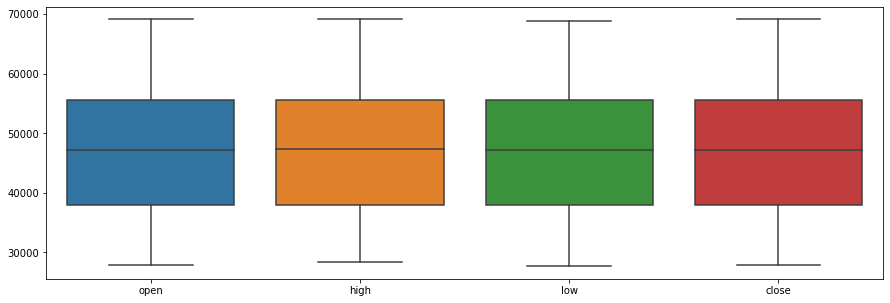

In [72]:
sns.boxplot(data=df[['open', 'high', 'low', 'close']])